
# Formation Pratique 7 : Régression, Biais et Variance

Au cours de cette démonstration nous allons nous intéresser aux problèmes de régressions et nous en servir pour illustrer des notions vues en cours : capacité des modèles, sur-apprentissage, sous-apprentissage, biais et variance. Cette première cellule de code importe des fonctions de visualisations dont nous nous servirons, vous pouvez les consulter sur https://github.com/charlesGE/MOOC_DataSciences/FP7/utilities. 
Certaines parties de cette démonstration ont été adaptées des notebooks de Laurent Charlin, avec son autorisation.

# <font color=”blue”>  Pratical Formation 7 : Regression, Bias and Variance 

During this demonstration we will focus on regression problems, and use them to illustrate some notions seen in class : model capacity, overfitting, underfitting, bias and variance. This first cell of code will import some visualization functions that we will use, you can consult them at https://github.com/charlesGE/MOOC_DataSciences/FP7/utilities. 
Some of the materials have been adapted from the notebooks of Laurent Charlin, with his permission. </font>



In [ ]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

!rm -rf DIRO-SD1FR
!git clone https://github.com/Cours-EDUlib/DIRO-SD1FR/
import sys
sys.path += [‘DIRO-SD1FR/FP/FP7/']

# We import several home functions in order to create graphics
from utilities import scatter_plot, plot_polynomial_curves, \
                      plot_optimal_curve, train_poly_and_see, MSE
%matplotlib inline

## 7.1 Capacité d'un modèle

Informellement, la capacité d'un modèle peut être definie comme le nombre de functions qu'un modèle peut apprendre. Un modèle de faible capacité pourrait parfaitement apprendre (c'est à dire obtenir une erreur d'entrainement de 0) un plus petit nombre de functions qu'un modèle de haute capacité.

Les modèles de haute capacité sont plus propices au **sur-apprentissage**. Le sur-apprentissage arrive quand l'écart entre les erreurs d'entrainement et de test est grand, ou en d'autres termes quand les modèles mémorisent les proprietés des données d'entrainement qui ne sont pas utiles (i.e. ne se généralisent pas) pour faire des prédictions sur des données de test.

Intuitivement, quand deux modèles apprennent les données d'entrainement aussi bien, c'est générelament celui de plus faible capacité qui géneralisera le mieux, c'est à dire qui obtiendra le moins d'erreur de test. C'est un bon exemple du https://en.wikipedia.org/wiki/Occam%27s_razor

## <font color=”blue”> 7.1 Model capacity 
<font color=”blue”>
Informally, the capacity of a model can be defined as the number of functions a model can fit. Lower-capacity models would be able to perfectly fit (i.e. obtain 0 train error) fewer functions than higher-capacity models. 

Higher-capacity models are generally more prone to **overfitting**. Overfitting occurs when the gap between the test and training error is large, or in other words, when models memorize properties of the training set that are not useful for (i.e. do not generalize to) performing predictions on a test set. </font>

Intuitively, when two models fit the training data equally well, usually the model with less capacity will generalize better, i.e. have lower test error. This is a good illustration of https://en.wikipedia.org/wiki/Occam%27s_razor) </font>


### 7.1.1 Génération de données

Commençons par simuler quelques données ! Dans cette section, chaque observation $y$ est générée suivant ce modèle:

$$ y = x \cos(x / \gamma) + \epsilon$$

Où $y \in \mathbb{R}$ est la sortie, $x \in \mathbb{R}$ sont les caractéristiques, $\gamma$ est la periode de la fonction cosine et $\epsilon$ le bruit aléatoire tel que $\epsilon \sim \mathcal{N}(0, \sigma^2)$ où VOUS définissez $\sigma$.

### <font color=”blue”> 7.1.1 Data generation

<font color=”blue”> Let's first simulate some data! In this section, every observation $y$ is generated according to the following model:

<font color=”blue”> $$ y = x \cos(x / \gamma) + \epsilon$$

<font color=”blue”> where $y \in \mathbb{R}$ is the output, $x \in \mathbb{R}$ are the features, $\gamma$ is the period of the cosine function and $\epsilon$ is the random noise such as $\epsilon \sim \mathcal{N}(0, \sigma^2)$ where $\sigma$ is defined by YOU.

In [3]:
def data_simulation(sample_size, scale, period, variance):
    
    x = np.random.uniform(-scale, scale, sample_size)
    x.sort()
    noise = np.random.normal(0, variance, sample_size)
    y = x * np.cos(x / period) + noise
    
    return x, y

Quand c'est possible, il est toujours bon de visualiser les données (afin d'obtenir une certaine intuition à leur propos). Utiliser la cellule suivante et jouez avec les valeurs de **sample_size**, **variance**, **scale** et **period** pour comprendre comment elles affectent nos données. Les données d'entrainement sont indiquées en noir, celles de test en rouge.

<font color=”blue”> Whenever it is possible, it is always a good idea to visualize the data (in order to get some intuition about them). Use the following cell and play with the values of **sample_size**, **variance**, **scale** and **period** to understand how they affect our data. Training data are indicated in black, while test data are red.

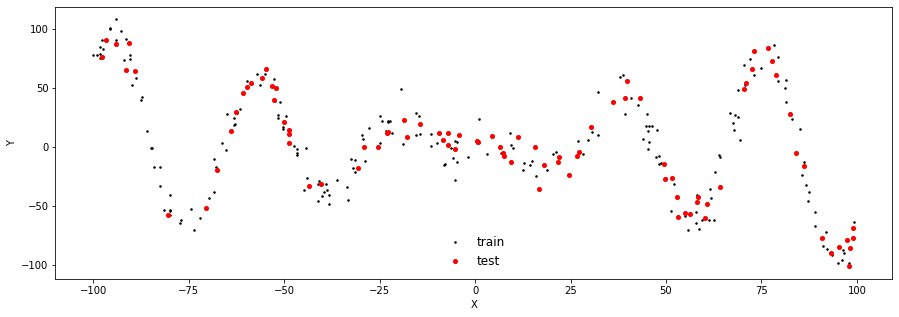

In [ ]:
sample_size = 150
variance = 10   # Variance of the Gaussian noise
scale = 100   # Range
period = 6   # Simulation are based on cosine function (see data_simulation function)

x_train, y_train = data_simulation(int(.7*sample_size), scale, period, variance)
x_test, y_test = data_simulation(int(.3*sample_size), scale, period, variance)

plt = scatter_plot(x_train, x_test, y_train, y_test)   # The scatter_plot function is in the utilities script

### 7.1.2 Obtenir une intuition visuelle de la capacité des modèles

Plus un modèle a une grande capacité, mieux il apprendra les données d'entrainement (attention cependant, bien apprendre les données d'entrainement ne mène pas automatiquement à une bonne généralisation). Ici, nous utilisons la [régression polynomiale](https://en.wikipedia.org/wiki/Polynomial_regression) (introduite au cours du module 6) pour apprendre les données d'entrainement. Le degré du polynome est un hyperparamètre important du modèle et plus le degré est élevé, plus le modèle aura une grande capacité.

**Questions (exécutez la cellule de code suivante)**:
1. Observez comment la courbe apprise évolue en fonction du degré du polynome.
2. Préféreriez-vous apprendre les données avec un polynome de degré 20 ou 50 ?
3. Laquelle de ces courbes devrait avoir la meilleur erreur de généralisation ?
4. Le code affiche également l'erreur MSE (moyenne de l'erreur quadratique) pour chaque degré envisagé. Si on sélectionne le degré avec la meilleure MSE sur les données de test, cette MSE sera-t-elle une bonne estimation des performances de notre modèle sur de nouvelles données ? Si non, que pourrions nous changer pour estimer correctement les performances du modèle selectionné sur de nouvelles données ?

### <font color=”blue”> 7.1.2 Getting visual intuition about models' capacity

<font color=”blue”> The higher the capacity of the model, the better it will fit the training data set (caution though, fitting the training data well does not necessarily lead to good generalization). Here, we use [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression) (introduced in module 6) to fit the training set. The polynomial degree is an important hyperparameter of the model and the higher the degree is, the higher the model capacity will be.

<font color=”blue”> **Questions (execute the code cell below)**: 
1. Observe how the fitted curve behave with respect to their polynomial degree. 
2. Would you prefer to fit the data points with polynomial regression of degree 20 or 50?
3. Which of these curves should have the best generalization error?
4. The code also prints the MSE error for each considered degree. If we select the degree with best test MSE, will this MSE be a be a good estimation of how our model will perform on new data points ? If not, what could we do to estimate the actual performance of our selected model on new data points ?

In [ ]:
degree = [0, 1, 3, 5, 10, 20, 50]   # Maximal polynomial degree of the fitted curve: higher degree == higher capacity

plot_polynomial_curves(x_train, x_test, y_train, y_test, degree, scale)

#### Réponses (essayez d'abord de répondre par vous-même avant de regarder la réponse)

#### <font color=”blue”> Answers (try to answer by yourself before looking at the answers)


Lorsque le degré augmente, la courbe polynomiale associée ressemble à une interpolation polynomiale. En regardant les données (première figure, Section 7.1.1), on peut voir un maximum de 15 minimums / maximums locaux. Par conséquent, la regression polynomiale de degré 50 semble excessive (trop grande capacité). En revanche, la regression polynomiale de degré 20 semble bien suivre la distribution des données. C'est confirmé par la MSE qui indique qu'un degré de 20 mène à la meilleure généralisation.

Attention cependant, car en choisissant le modèle avec les meilleures performances sur les données de test, on risque le sur-apprentissage des hyperparamètres. Ainsi, nous pourrions observer des performances différentes sur de nouvelles données. Pour obtenir une estimation fiable, il faudrait séparer le jeu de données en données d'entrainement, de validation et de test, puis sélectionner le degré du polynome basé sur les performances sur les données de validation, et on pourrait alors correctement estimer les performances du modèle choisi en utilisant les données de test, comme vu dans le module 7.

<font color=”blue”> As the degree increases, the associated polynomial curve looks like a polynomial interpolation. Looking at the dataset (first figure, Section 7.1.1), we can see at first sight a maximum of 15 local minima/maxima. Thus, polynomial regression with degree 50 seems overkill (too much capacity). On the other hand, polynomial regression with degree 20 seems to follow well the distribution of data. This is confirmed by the MSE which indicates that degree 20 leads to the best generalization

<font color=”blue”> We need to be careful though, because by choosing the model with the best test performances, we risk to overfit the hyperparameters. Thus, we could observe different performances on new test data. In order to obtain a robust estimation, we would have to split the data in training, validation and test, then select the polynomial degree based on the performances on the validation data, and finally we could correctly estimate the performances of the selected model on the test data, as seen in module 7.

### 7.1.3 Nombre de données et capacité des modèles

On étudie le comportement des regressions polynomiales et examinons leurs performances quand le nombre de données augmente. En particulier, on étudie le comportement de la regression polynomiale cubique (degré 3) et de la regression polynomiale optimale (celle de degré minimisant l'erreur MSE sur les données de test).

**Question**: Exécutez la cellule de code suivante. Est-ce que les courbes obtenues correspondent à ce qui est attendu ? Justifiez.

### <font color=”blue”> 7.1.3 Sample size and models' capacity

<font color=”blue”> We study the behavior of the polynomial regressors and examine how they perform when the sample size increases. Specifically, we study the behavior of the cubic polynomial regression (degree 3) and the optimal polynomial regression (with the degree that minimizes the MSE on the test set). 

<font color=”blue”> **Question**: Execute the following code cell. Do the curves behave as expected? Justify.

In [4]:
# Sample size of the training set that we want to study
sample_size = [10, 10**2, 10**3, 10**4, 10**5, 10**6]   
variance = 20

H_train, H_test, optimal_train, optimal_test, optimal_degree \
    = train_poly_and_see(sample_size, scale, period, variance, degree)

plot_optimal_curve(optimal_train, optimal_test, H_train, H_test, optimal_degree)

NameError: ignored

#### Réponses (essayez d'abord de répondre par vous-même avant de regarder la réponse)

#### <font color=”blue”> Answers (try to answer by yourself before looking at the answers)

Oui ! Sans avoir à réaliser l'experience, on s'attends à ce que :

1. L'erreur MSE sur les données de test diminue lorsque le nombre de données d'entrainement augmente.
2. Les courbes d'entrainement et de test coincident quand le nombre de données d'entrainement augmente, parce qu'il est plus difficile d'être en sur-apprentissage lorsque le nombre de données d'entrainement est grand.
3. La regression polynomiale cubique a une plus grande erreur MSE (que le modèle optimal) sur les données d'entrainement et de test quand on dispose de suffisament de données d'entrainement (par example $n > 100$).
4. Le degré optimal (celui pour lequel la regression polynomiale atteint la plus petite erreur MSE sur les données de test) augmente avec le nombre de données d'entrainement : plus on dispose de données d'entrainement, plus notre modèle devrait avoir une grande capacité.

<font color=”blue”> Yes! Without running the experiment, we should expect that:

1. The MSE on the test set decreases as the train set gets larger.
2. The training and the test curves overlap as the training set gets larger, because it is more difficult to overfit when the training set size is large.
3. Cubic polynomial regression has a greater MSE (than the optimal model) on both training and test sets given a large enough training set (say $n > 100$ for example).
4. The optimal degree (the one for which polynomial regression achieves the lowest MSE on the test set) increases with the training size : the more training data we have, the more capacity our model should have.

# 7.2 Biais et variance des estimateurs

Nous allons maintenant nous intéresser au biais et à la variance de certains estimateurs classiques.

# <font color=”blue”> 7.2 Bias and variance of estimators

<font color=”blue”> We will now explore some properties of the bias and variance of well-known estimators.

## Modèles linéaires de régression

Le problème d'apprentissage polynomiale vu précédement est un exemple d'une plus grande classe de modèles - les modèles linéaires. Plus précisemment, c'est un problème de régression linéaire, où le but est de prédire la valeur d'une ou plusieurs variables continues étant donné les valeurs de certaines variables d'entrée. Les modèles linéaires partagent la propriété **d'être une fonction linéaire des paramètres appris** (les coefficients du polynome dans le cas des modèles polynomiaux) mais pas nécessairement linéaires en les variables d'entrée.

Nous considérons maintenant que notre fonction de perte est l'erreur quadratique (i.e. $\sum_{i=0}^n (y_i-\hat{y}_i)^2$ ), et que notre modèle est une fonction linéaire des variables d'entrée.

Dans ce contexte, nous pouvons calculer analytiquement les paramètres optimaux de notre modèle pour les données d'entrainement. Ce modèle de regression linéaire entrainé pour minimiser l'erreur quadratique est aussi connu sous le nom de regression ordinary least square (OLS) et a été introduit lors du module 6.

Tout d'abord, simulons quelques données.

## <font color=”blue”> Linear models for regression

<font color=”blue”> The polynomial curve fitting problem encountered previously is an instance of a broader class of models - linear models. More specifically, it is a linear regression task, where the goal is to predict a value of one or more continuous target variables given the values of some input variables. Linear models share the property of **being a linear function of the adjustable parameters** (polynomial coefficients in case of polynomial models) but not necessarily linear in the input variables.

<font color=”blue”> We now consider that our loss function is the squared error (i.e. $\sum_{i=0}^n (y_i-\hat{y}_i)^2$ ), and that our model is a linear funtion of the input variables. 

<font color=”blue”> In this setup, we can analytically compute the optimal parameters of the model for the training data. This linear regression model fitted with a squared error is also known as an ordinary least square (OLS) regression and was introduced in module 6.

<font color=”blue”> First, let's simulate some data.

### 7.2.1 Simulation de données

Dans cette section, chaque observation $y$ est générée en suivant le modèle suivant:

$$ y = \bf{x}^\top \bf{w} + w_0 + \epsilon$$

où $y \in \mathbb{R}$ est la variable cible, $\bf{x}$ est le vecteur de covariables, $\bf{w_0}$ est un scalaire et $\epsilon$ est le bruit aléatoire avec $\epsilon \sim \mathcal{N}(0,1)$.

### <font color=”blue”> 7.2.1 Data simulation

<font color=”blue”> In this section, every observation $y$ is generated according to the following model:

<font color=”blue”> $$ y = \bf{x}^\top \bf{w} + w_0 + \epsilon$$

<font color=”blue”> where $y \in \mathbb{R}$ is the output, $\bf{x}$ is the vector of covariates,  $\bf{w}$ is the vector of the associated weights, $\bf{w_0}$ is a scalar and $\epsilon$ is the random noise such as $\epsilon \sim \mathcal{N}(0,1)$.

In [1]:
def data_simulation(sample_size, w_0, w_1):
    
    x = np.random.uniform(-1, 10, sample_size)
    x.sort()
    noise = np.random.normal(0, 1, sample_size)
    y = w_0 + w_1 * x + noise
    
    return x, y

Étant donné le modèle génératif ci-dessus, nous pouvons maintenant générer les données et les visualiser.

<font color=”blue”> Given the above generative model, we can now sample the data and visualize it.

In [ ]:
w_0, w_1 = 2, 3   # Fix w values
sample_size = 500   # Fix the sample size - train

X, y = data_simulation(sample_size, w_0, w_1)
X = [np.ones(len(y)), X] # We fill the first column of X with ones, as explained below
X = np.asarray(X ).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scatter_plot(X_train[:, 1], X_test [:, 1], y_train, y_test) 

### 7.2.2 Calcul des estimateurs OLS

Durant le cours, nous avons vu que l'estimateur OLS est obtenu par l'expression suivante :

$$ \hat{\bf{w}}^{\text{OLS}} := (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}$$

où $\bf{X}$ est la [matrice de conception](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.) et $\bf{y}$ est le vecteur de variables cibles. Notez qu'afin de calculer le terme $\bf{w_0}$, nous avons rempli la première colonne de $\bf{X}$ avec des uns (dans la cellule de code précédente), comme explicitement suggéré [ici](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.).

**Question**:

Remplissez la cellule de code suivante pour calculer l'estimateur OLS basé sur l'expression ci-dessus.

### <font color=”blue”> 7.2.2 Computation of the OLS estimators

<font color=”blue”> During the course, we have seen that the OLS estimator is given by the following expression :

<font color=”blue”> $$ \hat{\bf{w}}^{\text{OLS}} := (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}$$

<font color=”blue”> where $\bf{X}$ is the [design matrix](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.) and $\bf{y}$ is the output vector. Note that in order to compute the term $\bf{w_0}$, we have filled the first column of $\bf{X}$ with ones (in the previous code cell), as explicitely suggested [here](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.).

<font color=”blue”> **Question**: 

<font color=”blue”> Fill the following code cell to compute the OLS estimator based on the expression above.


In [ ]:
def OLS(X, y):  
    """
    X: design matrix
    y: output vector
    
    return:  array of weights
    """
        
    return (...) # this should return the vector w_OLS

w_ols = OLS(X_train, y_train)

#### Réponses (essayez d'abord de répondre par vous-même avant de regarder la réponse)

#### <font color=”blue”> Answers (try to answer by yourself before looking at the answers)

In [ ]:
def OLS(X, y):
    
    A = np.linalg.inv(np.dot(X.T, X))
    B = np.dot(X.T, y)
    
    return np.dot(A, B)

w_ols = OLS(X_train, y_train)

#### **Question**: 

Remplissez la cellule de code suivante pour effectuer les prédictions sur les données d'entrainement et de test et calculer l'erreur MSE associée.

#### <font color=”blue”> **Question**: 

<font color=”blue”> Fill the following code cell to make predictions on training and test sets and compute the associated MSE.

In [ ]:
# Train set
y_hat_train = (...) # Compute here the predictions on training data

# Test set
y_hat_test = (...) # Compute here the predictions on test data

print('MSE of the train: ', MSE(y_hat_train, y_train))
print('MSE of the test:  ', MSE(y_hat_test, y_test))

#### Réponses (essayez d'abord de répondre par vous-même avant de regarder la réponse)

#### <font color=”blue”> Answers (try to answer by yourself before looking at the answers)

In [ ]:
# Train set
y_hat_train = np.dot(X_train, w_ols)

# Test set
y_hat_test = np.dot(X_test, w_ols)

print('MSE of the train: ', MSE(y_hat_train, y_train))
print('MSE of the test:  ', MSE(y_hat_test, y_test))

### 7.2.3 Biais et variance des estimateurs OLS

L'estimateur OLS calculé dans la section précédente dépends des données générées et peut donc être vu comme une variable aléatoire. Par conséquent cet estimateur a une moyenne et une variance. Le biais de cet estimateur est simplement la différence entre sa moyenne et le $\bf{w}$ du modèle générant les données.

Il y a deux approches pour estimer le biais et la variance de l'estimateur OLS. Premièrement, il est possible de le calculer analytiquement (voir section 7.4 - Pour aller plus loin). Une autre méthode est de les estimer statistiquement : on génère plusieurs sets de variables de sortie $y$ et calculons pour chacun l'estimateur OLS correspondant. On calcule ensuite la moyenne des estimateurs obtenus (et en déduisons le biais) et leur variance. Plus on calcule un grand nombre d'estimateurs, plus ces estimations seront fiables. Note : le biais et la variance de l'estimateur OLS dépendent de la matrice de conception $\bf{X}$, qui est fixée dans notre cas (seul les $y$ peuvent changer lorsque nous générons les données).

**Question**: Remplissez la cellule de code ci-dessous en suivant les indications pour estimer le biais et la variance des estimateurs OLS. Que pouvez vous dire des résultats ?

### <font color=”blue”> 7.2.3 Bias and variance of the OLS estimators

<font color=”blue”> The OLS estimator calculated in the last section depends of the generated data and thus can be seen as a random variable. It follows that this estimator has a mean and variance. The bias of this estimator is simply the difference between its mean and the $\bf{w}$ of the data-generating model.

<font color=”blue”> There are two approaches to estimate the bias and variance of the OLS estimator. First, it is possible to compute it analytically in closed form (see section 7.4 - To go further). Another method is to estimate them statistically : we generate different sets of output data $y$ and compute each corresponding OLS estimator. We can then compute the mean of these estimators (and deduce the bias from it) and their variance. The more estimators we compute, the more reliable these estimations will be. Note : the bias and variance of the OLS estimator depend of the design matrix $\bf{X}$, which is fixed in our case (only the $y$ may change when we sample data).

<font color=”blue”> **Question**: Fill the following code cell following the indications to estimate the bias and variance of the OLS estimators. What can you tell about the results ?

In [ ]:
mc_estimates = 1000 # Number of estimators that you want to compute
M = np.zeros((mc_estimates, 2)) # Matrix to store the estimators

# Step 1: Create a loop 
for k in np.arange(mc_estimates):
    
    # Step 2: Data simulation for k-th estimator
    x, y = data_simulation( int(.8 * sample_size), w_0, w_1)
    
    X = [np.ones(len(y)), x]   
    X = np.asarray(X).T
    
    # Step 3: Compute the k-th estimator
    w_ols = (...) # Compute the OLS estimator here, using a function you filled previously
    M[k, :] = w_ols # Store the estimator
     
# Step 4: Compute the bias and variance of w_0 and w_1 (hint: np.var)
mean = (...) # Compute here the means of w_0 and w_1
bias = (...) # Compute here the biases of w_0 and w_1
var = (...) # Compute here the variances of w_0 and w_1

print("MC estimate of the bias of the w_0 estimate: ", (...))   # Print here the bias of w_0
print("MC estimate of the bias of the w_1 estimate: ", (...))   # Print here the bias of w_1
print("MC estimate of the variance of the w_0 estimate: ", (...))   # Print here the variance of w_0
print("MC estimate of the variance of the w_1 estimate: ", (...))   # Print here the variance of w_1

#### Réponses (essayez d'abord de répondre par vous-même avant de regarder la réponse)

#### <font color=”blue”> Answers (try to answer by yourself before looking at the answers)

In [ ]:
mc_estimates = 1000 # Number of estimators that you want to compute
M = np.zeros((mc_estimates, 2)) # Matrix to store the estimators

# Step 1: Create a loop 
for k in np.arange(mc_estimates):
    
    # Step 2: Data simulation for k-th estimator
    x, y = data_simulation( int(.8 * sample_size), w_0, w_1)
    
    X = [np.ones(len(y)), x]   
    X = np.asarray(X).T
    
    # Step 3: Compute the k-th estimator
    w_ols = OLS(X, y) # Compute the OLS estimator here, using a function you filled previously
    M[k, :] = w_ols # Store the estimator
    
# Step 4: Compute the bias and variance of w_0 and w_1 (hint: np.var)
mean_est = np.mean(M, axis=0) # Compute here the means of w_0 and w_1
bias = mean_est - [w_0, w_1] # Compute here the biases of w_0 and w_1
var = np.var(M, axis=0) # Compute here the variances of w_0 and w_1

print("MC estimate of the bias of the w_0 estimate: ", bias[0])   # Print here the bias of w_0
print("MC estimate of the bias of the w_1 estimate: ", bias[1])   # Print here the bias of w_1
print("MC estimate of the variance of the w_0 estimate: ", var[0])   # Print here the variance of w_0
print("MC estimate of the variance of the w_1 estimate: ", var[1])   # Print here the variance of w_1

Normalement, les variances et biais calculés devraient être très faibles, indiquant que l'estimateur OLS est très adapté à ce problème de regression. En fait, il est possible de calculer analytiquement le biais et la variance pour confirmer ces résultats. C'est ce que nous faisons dans la section suivante.

<font color=”blue”> The computed variances and biases should be very low, indicating that the OLS estimator is well suited for this regression problem. In fact, it is possible to analytically compute the bias and variance to confirm these results. This is what we will do in the following section.

## 7.4 Pour aller plus loin

On s'intéresse maintenant aux valeurs théoriques du biais et de la variance qui peuvent être calculées dans le cas de l'estimateur OLS.

## <font color=”blue”> 7.4 To go further

<font color=”blue”> We now focus on the theoretical values of the bias and variance that can be computed for the OLS estimator.

### 7.4.1 Calcul analytique du biais

Le calcul suivant permets d'obtenir la moyenne de l'estimateur OLS, et on observe immédiatement qu'il est non-biaisé ! En effet, $\mathbb{E}[\hat{\bf{w}}^{\text{OLS}}-\bf{w}] = 0$

Cela justifie le faible biais estimé statistiquement dans la section précédente. 

### <font color=”blue”> 7.4.1 Analytical computation of the bias

<font color=”blue”> The following computation gives us the mean of the OLS estimator, and we can immediately see that it is unbiased ! Indeed, $\mathbb{E}[\hat{\bf{w}}^{\text{OLS}}-\bf{w}] = 0$

<font color=”blue”> This justifies the low bias statistically estimated in the previous section.

\begin{align}
    \mathbb{E}[\hat{\bf{w}}^{\text{OLS}}] 
    &= \mathbb{E}[(\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \mathbb{E}[\bf{y}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \mathbb{E}[\bf{X} \bf{w} + \bf{\epsilon}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \{ \mathbb{E}[\bf{X} \bf{w}] + \mathbb{E}[\bf{\epsilon}] \} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \{ \bf{X} \bf{w} + \bf{O} \} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{X} \bf{w}  \\
    &= \bf{w}
\end{align}

### 7.4.2 Calcul analytique de la variance

Le calcul suivant nous permets d'obtenir la variance de l'estimateur OLS en fonction de la matrice de conception $\bf{X}$.

**Question**: remplissez la cellule de code suivante pour calculer la variance théorique de l'estimateur OLS. Comparez la à la variance estimée dans la section 7.3.

### <font color=”blue”> 7.4.2 Analytical computation of the variance

<font color=”blue”> The following computation gives us the variance of the OLS estimator, as a function of the design matrix $\bf{X}$.

<font color=”blue”> **Question**: fill the following code cell to compute the theoretical variance of the OLS estimator. Compare it to the variance estimated in section 7.3.

\begin{align}
    \text{Var}(\hat{\bf{w}}^{\text{OLS}}) 
    &= \text{Var}\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}\right) && \text{Definition of the OLS estimators}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y})\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \right)^\top && \text{Property of the variance on matrices} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y}) \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the transpose}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{X} \bf{w} + \bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Modelization of the data}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the variance (only $\epsilon$ is a random variable)} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{I} \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Since $\epsilon$ is iid}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top  \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= \left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= (\bf{X}^\top \bf{X})^{-1} && \text{Since $\bf{X}^\top \bf{X}$ is symetric and by property of the inverse of a matrix}
\end{align}

In [ ]:
# Computation
var = (...) # Use the expression above on X_train

# Interest
print("Analytical variance of the w_0 estimate: ", (...))   
print("Analytical variance of the w_1 estimate: ", (...))   

#### Réponses (essayez d'abord de répondre par vous-même avant de regarder la réponse)

#### <font color=”blue”> Answers (try to answer by yourself before looking at the answers)

In [ ]:
# Computation
var = np.linalg.inv(np.dot(X_train.T, X_train)) # Use the expression above on X_train

# Interest
print("Analytical variance of the w_0 estimate: ", var[0, 0])   
print("Analytical variance of the w_1 estimate: ",var[1, 1])   

On peut voir comme attendu que la valeur théorique de la variance est similaire à celle obtenue section 7.3.

<font color=”blue”> We can see that the theoretical value of variance is, as expected, similar to the one obtained in section 7.3.